#### Libraries importeren

In [46]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torchvision.utils as vutils
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt

#### Set seed

In [47]:
np.random.seed(42)
torch.manual_seed(42)

#### Dataset inladen en inzien
Voordat ik de data volledig ga transformeren, wil ik eerst het gemiddelde en de standaardafwijking weten voor de normalisatie. Daarnaast wil ik ook weten wat de grote van de afbeelding is qua pixels en het kanaal (grijstinten of rgb).

In [48]:
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

alle_afbeeldingen = torch.cat([image.unsqueeze(0) 
                               for image, _ in train_data], dim=0)

print(f"Gemiddelde: {alle_afbeeldingen.mean().item():.4f}, Standaardafwijking: {alle_afbeeldingen.std().item():.4f}")

Gemiddelde: 0.1307, Standaardafwijking: 0.3081


#### Data transformeren

In [49]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)), #Juiste afmetingen invoeren 
    transforms.RandomRotation(10),  #Willekeurige rotaties tot 10 graden
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), shear=10), #Willekeurige onregelmatigheden 
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.10), ratio=(0.3, 3.3)),
    transforms.Normalize((0.1307,), (0.3081,)) #Normalisatie op basis van het gem en standaardafwijking
])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

#### Train data inspecteren

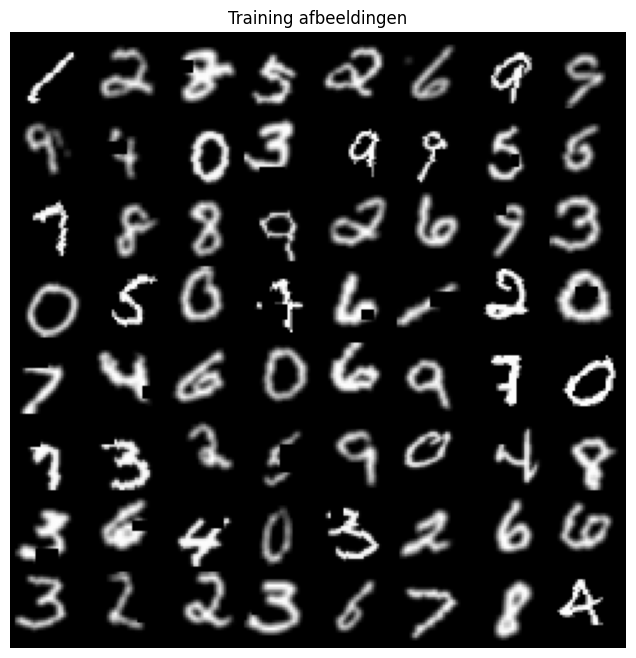

torch.Size([1, 28, 28])


In [50]:
eerste_batch = next(iter(train_loader))
images, labels = eerste_batch

plt.figure(figsize=(8,8))
plt.axis('off')
plt.title("Training afbeeldingen")

grid_afbeeldingen = np.transpose(vutils.make_grid(images[:64], padding=2, normalize=True), (1, 2, 0))

plt.imshow(grid_afbeeldingen)
plt.show()

#Formaat checken
image, label = test_data[0]
print(image.shape)

#### Architectuur van CNN bouwen

In [51]:
model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Flatten(),
    
    nn.Linear(128 * 3 * 3, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    
    nn.Linear(256, 10)
)

#### Check voor GPU
I.v.m. dat het model zwaar kan zijn, check ik eerst ff of het huidige apparaat een GPU heeft. Dit kan het trainen een stuk versneller namelijk.

In [52]:
component = torch.device("cuda" if torch.cuda.is_available()
                         else "cpu")
model = model.to(component)
print(f"Model runt op {component}")

Model runt op cuda


#### Model trainen

In [53]:
optimalisator = optim.Adam(model.parameters(), lr=0.0001)
criterium = nn.CrossEntropyLoss()

In [54]:
epochs = 10
for epoch in range(epochs):
    model.train()
    totale_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(component), labels.to(component) #Runt het model op geschikte component
        
        optimalisator.zero_grad()
        output = model(images)
        loss = criterium(output, labels)
        loss.backward()
        optimalisator.step()
        totale_loss += loss.item()
    
    print(f"Epoch {epoch + 1}, Loss: {totale_loss / len(train_loader)}")

torch.save(model.state_dict(), "Getrainde_modellen/CNN_Model_gewichten.pth")

Epoch 1, Loss: 0.5313259293275602
Epoch 2, Loss: 0.20081820215648616
Epoch 3, Loss: 0.1551022479173614
Epoch 4, Loss: 0.1330422254245498
Epoch 5, Loss: 0.12141473671006384
Epoch 6, Loss: 0.10854551996459871
Epoch 7, Loss: 0.10103214832731704
Epoch 8, Loss: 0.09590678334708756
Epoch 9, Loss: 0.09345601169195876
Epoch 10, Loss: 0.08767175128254523


#### Laad getrainde model indien nodig (voor apparaten zonder cuda bijvoorbeeld)

In [55]:
model.load_state_dict(torch.load("Getrainde_modellen/CNN_Model_gewichten.pth", 
                                 map_location=torch.device(component)))


<All keys matched successfully>

#### Evaluatie van model

In [56]:
model.eval()
with torch.no_grad():
    correct_voorspeld = 0
    totaal_voorspeld = 0
    for images, labels in test_loader:
        images, labels = images.to(component), labels.to(component)
        test_output = model(images)
        _, predicted = torch.max(test_output, 1)
        correct_voorspeld += (predicted == labels).sum().item()
        totaal_voorspeld += labels.size(0)

accuratie = correct_voorspeld / totaal_voorspeld * 100

print("Werkelijke labels:", labels[:16].tolist())  
print("Voorspelde labels:", predicted[:16].tolist()) 
print(f"Accuratie na training: {accuratie:.2f}%")

Werkelijke labels: [1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6]
Voorspelde labels: [1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6]
Accuratie na training: 97.81%


#### Klassen en functies maken voor nieuwe data inzien en verwerken

In [57]:
## Transform functie maken
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomInvert(p=1),
    transforms.GaussianBlur(3, sigma=(1.5, 1.5)),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

## Handschrift dataset klas maken
class HandSchriftDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths= []
        self.labels = []

        for i in range(1, 10):
            path = f"{root_dir}/Nummer{i}.jpg"
            if not os.path.exists(path):
                print(f"Waarschuwing: {path} niet gevonden. Wordt overgeslagen.")
                continue
            self.image_paths.append(path)
            self.labels.append(i)

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]

        afbeelding = Image.open(image_path).convert("L")
        afbeelding = np.array(afbeelding)       
        afbeelding = (afbeelding > 100) * 255 #Afbeelding binariseren
        afbeelding = Image.fromarray(afbeelding.astype(np.uint8))

        #Transformeren van afbeelding
        if self.transform:
            afbeelding = self.transform(afbeelding)

        return afbeelding, label

#### Data transformeren en inspecteren

torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])


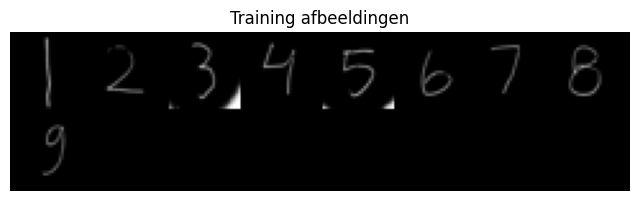

In [58]:
test_dataset = HandSchriftDataset("Afbeeldingen", transform=transform)

afbeeldingen = []
for i in range(0, len(test_dataset)):
    image, label = test_dataset[i]
    afbeeldingen.append(image)
    print(image.shape)

afbeeldingen = torch.stack(afbeeldingen)

plt.figure(figsize=(8,8))
plt.axis('off')
plt.title("Training afbeeldingen")

grid_afbeeldingen = np.transpose(vutils.make_grid(afbeeldingen, padding=2, normalize=True), (1, 2, 0))

plt.imshow(grid_afbeeldingen)
plt.show()

#### Nieuwe data introduceren in CNN

In [59]:
model.eval()
correct_voorspeld = 0
totaal_voorspeld = 0
with torch.no_grad():
    images = torch.stack([data[0] for data in test_dataset])
    labels = torch.tensor([data[1] for data in test_dataset], dtype=torch.long)

    images, labels = images.to(component), labels.to(component)
    test_output = model(images)
    _, predicted = torch.max(test_output, 1) 
    correct_voorspeld += (predicted == labels).sum().item()
    totaal_voorspeld += labels.size(0)

accuratie = correct_voorspeld / totaal_voorspeld * 100

print("Werkelijke labels:", labels[:9].tolist())  
print("Voorspelde labels:", predicted[:9].tolist()) 
print(f"Accuratie na training: {accuratie:.2f}%")
        

Werkelijke labels: [1, 2, 3, 4, 5, 6, 7, 8, 9]
Voorspelde labels: [1, 2, 3, 4, 5, 6, 7, 8, 9]
Accuratie na training: 100.00%
